Tem vários jeitos de classificar as amostras por tipo de movimento do olhar (fixação, sacada, smooth pursuit, etc). Como você só está interessado em fixações, talvez o jeito mais simples seja um processamento online: você sempre guarda a fixação atual (lista de pontos + centroide atualizado + última amostra). Se a velocidade (posição atual - posição anterior) for menor do que um threshold, você adiciona na fixação atual. Senão você termina a fixação anterior e começa uma nova

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

# **Clustering Algorithm**

In [20]:
def toshi_clustering(points: list[tuple[float]], threshold: float):

    valid_clusters = []
    valid_centroids = []

    # Cluster atual apenas com o primeiro ponto
    cluster = [points[0]]
    centroid = points[0]

    # Itera sobre pontos a partir do segundo
    for i in range(1, len(points)):
        
        # Se a posicao do atual menos a do anterior for menor que o threshold, adiciona na lista do cluster atual e atualiza a centroide
        if distance(points[i], points[i-1]) <= threshold:
            cluster.append(points[i])
            centroid = calculate_centroid(cluster)

        # Se nao, finaliza o cluster e comeca um novo cluster a partir daquele ponto
        else:
            # Checa se eh um cluster valido
            if len(cluster) > 20:
                valid_clusters.append(copy.copy(cluster))
                valid_centroids.append(copy.copy(centroid))

            cluster = [points[i]]
            centroid = points[i]
    
    # Adiciona o ultimo cluster
    if len(cluster) > 20:
        valid_clusters.append(cluster)
        valid_centroids.append(centroid)
    
    return valid_clusters, valid_centroids


def distance(p1: tuple[float], p2: tuple[float]) -> float:
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def calculate_centroid(points: list[tuple[float]]) -> tuple[float]:
    x = sum([p[0] for p in points]) / len(points)
    y = sum([p[1] for p in points]) / len(points)
    return (x, y)

# **Testing**

In [47]:
df_points = pd.read_csv('./collection_v1.csv')

# Filter out negative y
df_points = df_points[df_points['y'] > 0]

df_points = df_points.groupby('word_id')

df_points.head()

,word_id,word,time,x,y
19,1,CAPABLE,0.316667,0.499971,0.151639
20,1,CAPABLE,0.333333,0.602682,0.334425
21,1,CAPABLE,0.350000,0.589112,0.327795
22,1,CAPABLE,0.366667,0.609580,0.330112
23,1,CAPABLE,0.383333,0.582054,0.337577
227,2,PROCESS,0.116667,-0.254430,0.028824
228,2,PROCESS,0.133333,-0.288628,0.122506
229,2,PROCESS,0.150000,-0.277438,0.142353
230,2,PROCESS,0.166667,-0.302278,0.138850
231,2,PROCESS,0.183333,-0.278987,0.143393


In [48]:
first_group = df_points.get_group(3)

clusters, centroids = toshi_clustering(first_group[['x', 'y']].values, 0.1)

len(clusters)

8

In [49]:
for c in clusters:
    print(len(c))

30
22
30
34
21
48
32
37


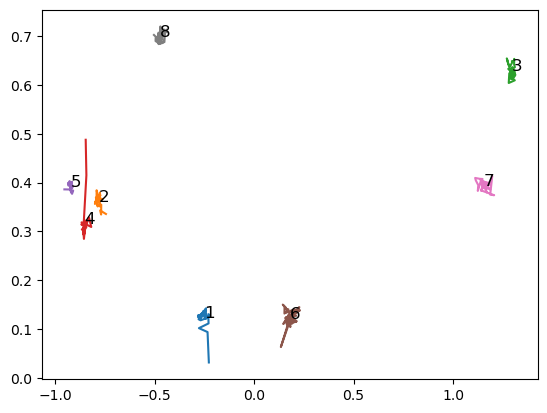

In [56]:
for c in clusters:
    plt.plot([p[0] for p in c], [p[1] for p in c])

# Plot the number of the cluster
for i, c in enumerate(centroids):
    plt.text(c[0], c[1], i+1, fontsize=12)

In [51]:
def create_keyboard(path: str, KEY_LENGTH=.2) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
    
    keyboard = {}
    for line in lines:
        key, center = line.strip().split()

        center = center.replace('(', '').replace(')', '')

        center_x, center_y = center.split(',')
        center_x, center_y = float(center_x), float(center_y)

        keyboard[key] = (
            (center_x, center_y), # Center (x, y)
            (center_x - KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top left
            (center_x + KEY_LENGTH/2, center_y + KEY_LENGTH/2), # Top right
            (center_x + KEY_LENGTH/2, center_y - KEY_LENGTH/2), # Bottom right
            (center_x - KEY_LENGTH/2, center_y - KEY_LENGTH/2)  # Bottom left
        )
    
    return keyboard

In [52]:
kb = create_keyboard('../data/keyboard2.txt')

In [53]:
def find_key_centroid(centroids, keyboard):
    
    i = 1
    for centroid in centroids:
        distances = {}
        for key, points in keyboard.items():
            center, top_left, top_right, bottom_right, bottom_left = points
            distance = np.linalg.norm(np.array(centroid) - np.array(center))
            distances[key] = distance
        
        # Print 3 smallest distances
        sorted_distances = sorted(distances.items(), key=lambda x: x[1])

        print(f"Cluster {i}: " + ', '.join([f"{key} ({distance:.2f})" for key, distance in sorted_distances[:3]]))
        i += 1

In [54]:
find_key_centroid(centroids, kb)

Cluster 1: C (0.07), V (0.28), X (0.30)
Cluster 2: A (0.17), Z (0.17), S (0.19)
Cluster 3: O (0.13), L (0.16), P (0.26)
Cluster 4: Z (0.13), A (0.16), S (0.27)
Cluster 5: A (0.08), Z (0.23), S (0.30)
Cluster 6: B (0.14), V (0.17), G (0.35)
Cluster 7: K (0.13), L (0.19), M (0.36)
Cluster 8: E (0.06), W (0.25), D (0.26)


In [59]:
for word_id, group in df_points:
    print(f"Word {word_id}")
    clusters, centroids = toshi_clustering(group[['x', 'y']].values, 0.2)
    find_key_centroid(clusters, kb)
    print()

Word 1
Cluster 1: J (0.86), H (1.30), N (1.40)
Cluster 2: I (0.84), K (0.93), O (0.96)
Cluster 3: H (0.89), G (1.31), Y (1.83)
Cluster 4: N (0.38), B (0.98), H (1.14)
Cluster 5: Y (0.56), T (1.09), G (1.41)

Word 2
Cluster 1: C (0.28), X (1.34), V (1.51)
Cluster 2: A (0.77), S (1.01), Z (1.21)
Cluster 3: B (0.36), V (1.16), G (1.60)
Cluster 4: A (0.53), Z (0.94), S (1.43)
Cluster 5: L (1.39), O (1.73), K (2.02)
Cluster 6: E (0.38), D (1.20), W (1.35)

Word 3
Cluster 1: C (0.42), V (1.58), X (1.65)
Cluster 2: A (0.80), Z (0.82), S (0.88)
Cluster 3: O (0.76), L (0.93), P (1.46)
Cluster 4: A (1.05), Z (1.30), S (2.11)
Cluster 5: B (0.97), V (1.22), G (2.43)
Cluster 6: K (0.75), L (1.09), M (2.03)
Cluster 7: E (0.66), D (1.75), R (1.99)

Word 4
Cluster 1: C (0.34), D (1.41), X (1.48)
Cluster 2: A (1.09), Z (1.45), S (1.94)
Cluster 3: O (1.11), L (1.57), P (1.89)
Cluster 4: A (0.95), Z (1.92), S (2.55)
Cluster 5: B (0.70), V (1.81), G (2.24)
Cluster 6: K (0.87), L (2.32), M (2.44)
Cluster 7

In [67]:
df_points_2 = pd.read_csv('./collection_v2.csv')

# Filter out negative y
df_points_2 = df_points_2[df_points_2['y'] > 0]

df_points_2 = df_points_2.groupby('word_id')

for word_id, group in df_points_2:
    print(f"Word {word_id}")
    clusters, centroids = toshi_clustering(group[['x', 'y']].values, 0.2)
    find_key_centroid(centroids, kb)
    print()

Word 1
Cluster 1: J (0.06), K (0.24), U (0.28)
Cluster 2: O (0.14), I (0.15), K (0.25)
Cluster 3: H (0.05), G (0.23), Y (0.26)
Cluster 4: N (0.13), B (0.18), H (0.35)
Cluster 5: Y (0.08), T (0.21), G (0.28)

Word 2
Cluster 1: G (0.05), B (0.24), H (0.28)
Cluster 2: R (0.09), E (0.21), D (0.25)
Cluster 3: E (0.06), W (0.23), S (0.28)
Cluster 4: A (0.01), S (0.28), Q (0.29)
Cluster 5: T (0.09), R (0.20), F (0.28)
Cluster 6: R (0.12), E (0.17), D (0.26)

Word 3
Cluster 1: G (0.07), F (0.21), T (0.26)
Cluster 2: R (0.08), E (0.25), F (0.25)
Cluster 3: E (0.05), W (0.24), D (0.28)
Cluster 4: A (0.01), S (0.27), Q (0.29)
Cluster 5: T (0.10), R (0.18), F (0.28)
Cluster 6: E (0.06), D (0.24), R (0.29)
Cluster 7: R (0.08), E (0.21), D (0.27)

Word 4
Cluster 1: G (0.13), B (0.19), V (0.22)
Cluster 2: S (0.13), W (0.20), E (0.22)
Cluster 3: R (0.04), T (0.26), F (0.26)
Cluster 4: R (0.08), E (0.24), F (0.26)

Word 5
Cluster 1: G (0.13), F (0.19), V (0.22)
Cluster 2: D (0.11), E (0.20), R (0.24)
C